## Total Electron Content (TEC) from JPL GIM

+ One figure with multi subplots for the distance map view of all dates

In [1]:
%matplotlib inline
import os
import re
import glob
import pickle
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from unwrap_error.simulation import iono
from offset import utils
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]


box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

# dir
proj_dir = os.path.expanduser('~/data/Tarapaca/SenAT149')
work_dir = os.path.join(proj_dir, 'offset_comp', box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

# config for GIM TEC data
gim_tec_dir = os.path.join(proj_dir, 'GIM_TEC_v2')
print('GIM TEC data dir: {}'.format(gim_tec_dir))

out_file = os.path.join(work_dir, 'TECgim.pickle')
print('output file     : {}'.format(out_file))

Go to directory /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR
GIM TEC data dir: /Users/yunjunz/data/Tarapaca/SenAT149/GIM_TEC_v2
output file     : /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECgim.pickle


### 1. calc / write GIM TEC

In [2]:
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')
atr = readfile.read_attribute(geom_file)
y = int((box[1] + box[3]) / 2)
x = int((box[0] + box[2]) / 2)
box = (x, y, x+1, y+1)

# geometry on the ground
head_angle = float(atr['HEADING'])
inc_angle_ground = readfile.read(geom_file, datasetName='incidenceAngle', box=box)[0][0,0]
lat_ground = readfile.read(geom_file, datasetName='latitude',  box=box)[0][0,0]
lon_ground = readfile.read(geom_file, datasetName='longitude', box=box)[0][0,0]

# geometry at the ionospheric shell
iono_height = 450e3     # height of the ionospheric piercing point in m
inc_angle_iono = ut.incidence_angle_ground2iono_shell_along_los(inc_angle_ground, iono_height=iono_height)
lat_iono, lon_iono = ut.lalo_ground2iono_shell_along_los(lat_ground, lon_ground,
                                                         inc_angle=inc_angle_ground,
                                                         head_angle=head_angle,
                                                         iono_height=iono_height)

print('heading   angle: {:.1f} deg'.format(head_angle))
print('incidence angle on the ground: {:.1f} deg'.format(inc_angle_ground))
print('incidence angle at ionosphere: {:.1f} deg'.format(inc_angle_iono))
print('SAR scene center on the ground in lat/lon: {:.1f}/{:.1f}'.format(lat_ground, lon_ground))
print('SAR scene center at ionosphere in lat/lon: {:.1f}/{:.1f}'.format(lat_iono, lon_iono))
print('SAR acquisition time UTC: {} hours'.format(float(atr['CENTER_LINE_UTC']) / 3600.))

# calc / interpolate / write GIM TEC
date_list, gim_tec, top_tec, sub_tec, gTecList = iono.get_gim_tec(gim_tec_dir, lat_iono, lon_iono, interp_method='median')
tDict = utils.save_gim_tec(out_file, date_list, gim_tec, top_tec, sub_tec, inc_angle=inc_angle_iono)

heading   angle: -13.9 deg
incidence angle on the ground: 44.9 deg
incidence angle at ionosphere: 41.2 deg
SAR scene center on the ground in lat/lon: -21.3/-67.4
SAR scene center at ionosphere in lat/lon: -17.8/-68.3
SAR acquisition time UTC: 23.1075 hours
calc range_delay4Lband_TEC     from TEC            
calc range_delay4Lband_subTEC  from subTEC         
calc range_delay4Lband_topTEC  from topTEC         
calc range_delay4Sband_TEC     from TEC            
calc range_delay4Sband_subTEC  from subTEC         
calc range_delay4Sband_topTEC  from topTEC         
calc range_delay4Cband_TEC     from TEC            
calc range_delay4Cband_subTEC  from subTEC         
calc range_delay4Cband_topTEC  from topTEC         
save data to file: /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECgim.pickle


### 2.1 plot - subTEC

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/subTECgim.png


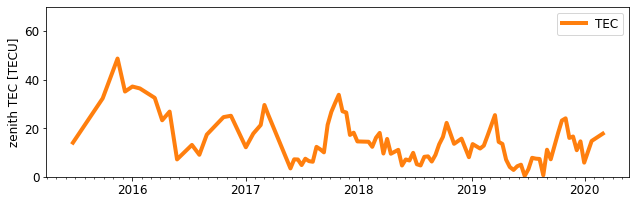

In [3]:
## plot
def plot_sub_tec_ts(tDict, suffix=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(tDict['time'], tDict['subTEC'], linewidth=4, color='C1', label='TEC')
    pp.auto_adjust_xaxis_date(ax, tDict['time'], every_year=1, buffer_year=None)
    ax.set_ylabel('zenith TEC [TECU]')
    ax.set_ylim(0, 70)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.legend()
    fig.tight_layout()

    # output
    out_fig = os.path.join(os.path.dirname(out_file), 'subTECgim{}.png'.format(suffix))
    print('save figure to file', out_fig)
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()
    return

plot_sub_tec_ts(tDict)

### 2.2 plot - delay prediction

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECgim_pred.png


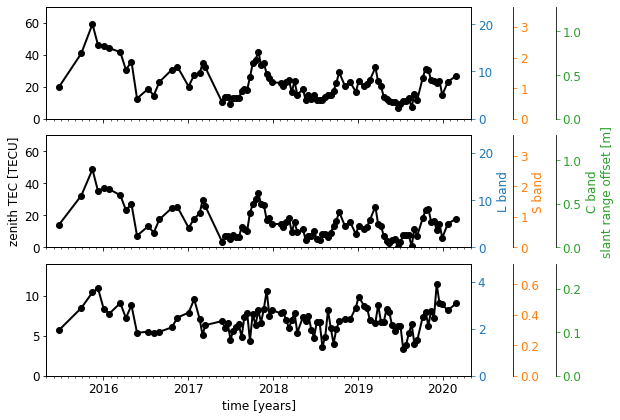

In [12]:
## data
tec_types = ['TEC', 'subTEC', 'topTEC']
bands = ['Cband', 'Sband', 'Lband']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 6], sharex=True)
for i in range(len(bands)):
    tec_type = tec_types[i]

    ## plot
    ax = axs[i]
    ax.plot(tDict['time'], tDict[tec_type], '-o', label=tec_type, color='k', ms=6, lw=2)

    # axis format
    if i in [0, 1]:
        ax.set_ylim(0, 70)
    else:
        ax.set_ylim(0, 14)

    #ax.annotate(tec_type, xy=(0.23, 0.8), xycoords='axes fraction')

    # TEC ytick
    colors = ['C0', 'C1', 'C2']
    for j in range(len(bands)):
        band = bands[2-j]
        key_off = 'range_delay4{b}_{t}'.format(b=band, t=tec_type)
        pos = 1.0 + 0.1 * j
        c = colors[j]
        label = '{} band'.format(band.split('band')[0])
        if j == 2:
            label += '\nslant range offset [m]'

        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', pos))
        ax2.tick_params(which='both', axis='y', colors=c)

        ratio = ((np.max(tDict[key_off])  - np.min(tDict[key_off])) /
                 (np.max(tDict[tec_type]) - np.min(tDict[tec_type])))
        ax2.set_ylim(ymin=ax.get_ylim()[0] * ratio,
                     ymax=ax.get_ylim()[1] * ratio)

        if i == 1:
            ax2.set_ylabel(label, color=c)

pp.auto_adjust_xaxis_date(axs[-1], tDict['time'], every_year=1, buffer_year=None)
axs[-1].set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
axs[-1].set_xlabel('time [years]')
axs[1].set_ylabel('zenith TEC [TECU]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# output
out_fig = os.path.join(os.path.dirname(out_file), 'TECgim_pred.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Backups

### 1. latitude distance between TEC TPP and SAR

min/max distance : 0.0/3.4 deg
save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECgim_latDist.png


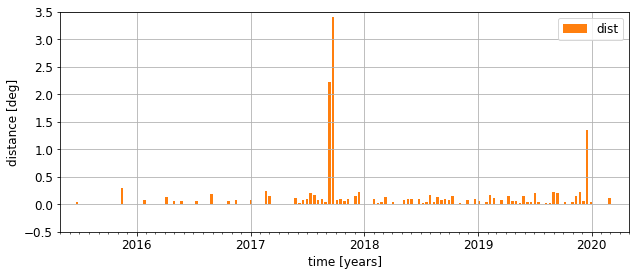

In [5]:
# calc nearest TOP TEC in latitude only
num_date = len(date_list)
lat_dist = np.zeros(num_date, dtype=np.float32)
for i in range(num_date):
    lats = gTecList[i]['lat']
    lat_dist[i] = np.min(np.abs(lats - lat_iono))
print('min/max distance : {:.1f}/{:.1f} deg'.format(np.min(lat_dist), np.max(lat_dist)))

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.bar(tDict['time'], lat_dist, width=8, color='C1', label='dist')
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.5, 3.5)
ax.set_xlabel('time [years]')
ax.set_ylabel('distance [deg]')
pp.auto_adjust_xaxis_date(ax, tDict['time'], every_year=1, buffer_year=None)
ax.grid('on')

ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'TECgim_latDist.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 2. location between TEC TPP and SAR

[==================================================] 20200228    0s /     0s 
save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/TECgim_loc.png


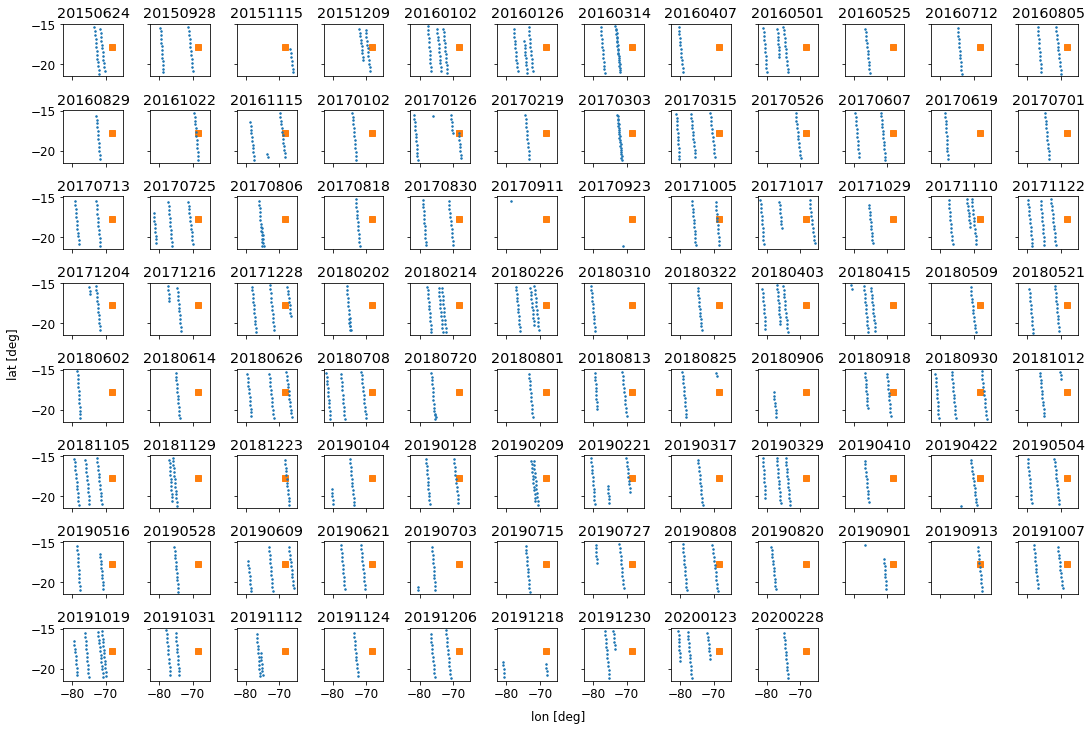

In [10]:
fig, axs = plt.subplots(figsize=[15, 10], nrows=8, ncols=12, sharex=True, sharey=True)
prog_bar = ptime.progressBar(maxValue=num_date)
for i in range(num_date):
    ax = axs.flatten()[i]
    lats = gTecList[i]['lat']
    lons = gTecList[i]['lon']

    # plot
    ax.plot(lon_iono, lat_iono, 's', color='C1', label='TGT')                   # SAR
    ax.plot(lons,     lats,     '.', color='C0', label='TPP', ms=3)             # TPP
    ax.set_title(date_list[i])

    prog_bar.update(i+1, suffix=date_list[i])
prog_bar.close()

for i in range(num_date, axs.size):
    axs.flatten()[i].set_visible(False)

# axis format
fig.text(0.5, -0.01, 'lon [deg]', ha='center')
fig.text(-0.01, 0.5, 'lat [deg]', va='center', rotation='vertical')
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'TECgim_loc.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3. Impact of interpolation method for TOPTEC

TOP TEC from **median** gives the smallest final residual (SAR - subTEC - ERA5 - SET).

save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/subTECgim_nearestLatLon.png


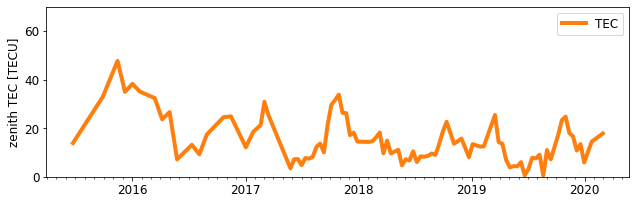

TOP TEC interpolation method of   nearestLatLon with final residual: 6.62 cm
save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/subTECgim_nearest.png


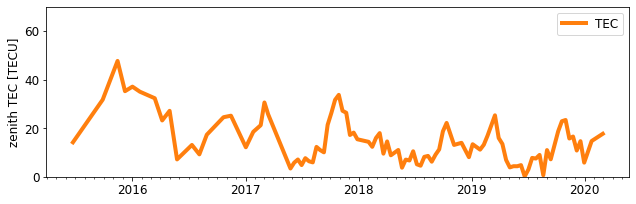

TOP TEC interpolation method of         nearest with final residual: 6.42 cm
save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/subTECgim_linear.png


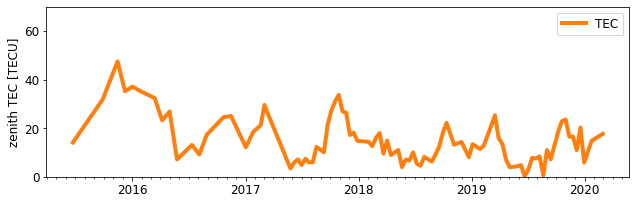

TOP TEC interpolation method of          linear with final residual: 6.57 cm
save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/subTECgim_mean.png


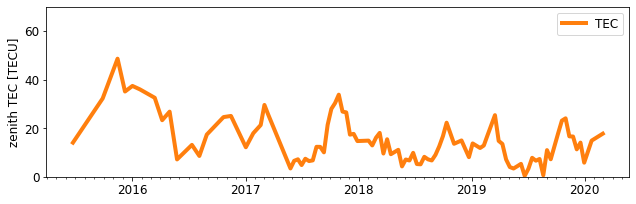

TOP TEC interpolation method of            mean with final residual: 6.49 cm
save figure to file /Users/yunjunz/data/Tarapaca/SenAT149/offset_comp/boxLR/subTECgim_median.png


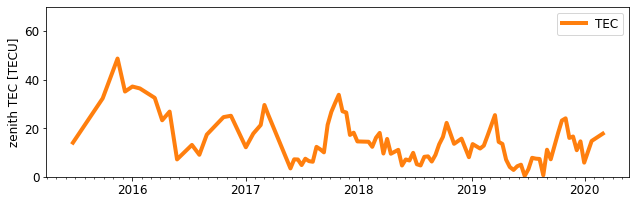

TOP TEC interpolation method of          median with final residual: 6.35 cm


In [11]:
interp_methods = ['nearestLatLon', 'nearest', 'linear', 'mean', 'median']
for interp_method in interp_methods:

    # calc / write / plot GIM TEC pickle file
    fname = os.path.join(work_dir, 'TECgim_{}.pickle'.format(interp_method))
    date_list, gim_tec, top_tec, sub_tec = iono.get_gim_tec(gim_tec_dir, lat_iono, lon_iono, interp_method=interp_method)[:4]
    tDict = utils.save_gim_tec(fname, date_list, gim_tec, top_tec, sub_tec, inc_angle=inc_angle_iono, print_msg=False)
    plot_sub_tec_ts(tDict, suffix='_{}'.format(interp_method))

    # read offsets from all sources
    fbaseDict={
        'SAR' : 'sar',
        'GIM' : 'TECgim_{}'.format(interp_method),
        'IGS' : 'TECigs',
        'ERA' : 'era5',
        'SET' : 'set',
    }
    dDict, flag = utils.read_offset_files(work_dir, fbaseDict, print_msg=False)

    # Calculate final residual: SAR - subTEC - ERA5 - SET
    x1  = dDict['GIM']['time']
    y1  = dDict['SAR']['range_offset_med'][flag]
    y1 -= dDict['GIM']['range_delay4Cband_subTEC']
    y1 -= dDict['ERA']['range_delay_tropo_med'][flag]
    y1 -= dDict['SET']['range_delay_SET_med'][flag] * -1

    # temporal referencing
    dt_s1ab = dt.datetime(2016, 10, 7)    # dateime separating S1A and S1B
    y1 -= np.median(y1[x1 > dt_s1ab])

    # residual RMSE
    rmse = np.sqrt(np.sum(y1 **2) / (y1.size - 1))

    print('TOP TEC interpolation method of {:>15} with final residual: {:.2f} cm'.format(interp_method, rmse*100))